# March 9-20, 2023: Linear EI balance model: modular network

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
from scipy.spatial.distance import pdist, cdist, squareform
from scipy import stats
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/mar23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

In [2]:
def generate_module(args, module=0):
    W = sp.sparse.random(
        m=args.num_rois[module],
        n=args.num_rois[module],
        density=args.density[module],
    ).A
    W = (W + W.T) / 2
    # W = (W > 0).astype(np.float32)
    np.fill_diagonal(W, 0.0)
    weights = args.scale * W

    return weights

def generate_off_diagonal_block(args, idx_blk1, idx_blk2):
    W = sp.sparse.random(
        m=args.num_rois[idx_blk1],
        n=args.num_rois[idx_blk2],
        density=0.25, #(args.density[idx_blk1]+args.density[idx_blk2])/2,
    ).A
    # W = (W > 0).astype(np.float32)
    weights = -args.scale * W
    if idx_blk1 == 0 and idx_blk2 == 2:
        weights *= 0.0
    return weights

def arrange_submatrices(args, blocks):
    rows = []
    for idx_blk1 in range(len(blocks)):
        rows.append(np.hstack(blocks[idx_blk1]))
    mat = np.vstack(rows)
    return mat

def generate_connectivity_matrix(args, ):
    # generate connections between two set of rois
    blocks = [
        [
            None 
            for _ in range(len(args.num_rois))
        ]
        for _ in range(len(args.num_rois))
    ]
    for idx_blk1 in range(len(blocks)):
        for idx_blk2 in range(len(blocks[idx_blk1])):
            if idx_blk1 == idx_blk2:
                # intra-group excitatory connections
                blocks[idx_blk1][idx_blk2] = generate_module(args, module=idx_blk1)
            elif idx_blk2 > idx_blk1:
                # inter-group inhibitory connections
                blocks[idx_blk1][idx_blk2] = generate_off_diagonal_block(args, idx_blk1, idx_blk2)
            elif idx_blk2 < idx_blk1:
                blocks[idx_blk1][idx_blk2] = blocks[idx_blk2][idx_blk1].T

    # combine all blocks
    weights = arrange_submatrices(
        args, 
        blocks
    )
    roi_labels = []
    for idx_blk in range(len(blocks)):
        # roi labels
        label = args.group_label[idx_blk]
        rls = [f"{label}_{roi+1:02}" for roi in range(args.num_rois[idx_blk])]
        roi_labels += rls

    return (
        weights, 
        roi_labels,
    )

In [3]:
def create_matrix_ticks(args):
    args.ticks = args.num_rois
    minor_ticks = np.cumsum(args.ticks)
    args.major_ticks = minor_ticks - args.ticks // 2 - 1
    args.minor_ticks = minor_ticks[:-1]
    args.major_tick_labels = args.group_label
    return args

def set_matrix_ticks(args, ax):
    try:
        ax.set_yticks(args.major_ticks, args.major_tick_labels, rotation=0, va='center')
        ax.set_xticks(args.major_ticks, args.major_tick_labels, rotation=90, ha='center')

        ax.set_yticks(args.minor_ticks-0.5, minor=True)
        ax.set_xticks(args.minor_ticks-0.5, minor=True)
        ax.tick_params(
            which='major', direction='out', length=5.5, 
            # grid_color='white', grid_linewidth='1.5',
            labelsize=10,
        )
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1.5)
    except:
        pass
    
def display_network(args, network):
    nrows, ncols = 1, 1
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    ax = axs
    im = ax.imshow(network, cmap=args.cmap, vmin=-1, vmax=1)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"network")
    set_matrix_ticks(args, ax)

    return None

In [4]:
def display_networks(args, networks) -> None:
    nrows, ncols = 1, len(networks)
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx, network in enumerate(networks):
        ax = axs[idx]
        im = ax.imshow(network, cmap=args.cmap, vmin=-1, vmax=1)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_title(f"{idx:02}: {args.networks[idx].name}")
        set_matrix_ticks(args, ax)

    return None

def get_min_max(fc):
    fc = fc.flatten()
    vmin, vmax = np.min(fc), np.max(fc)
    return -max(vmin, vmax), max(vmin, vmax)

def display_fcs(args, networks, fcs) -> None:
    nrows, ncols = args.num_subjs, 1+args.num_sigmas
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=False, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=0.5, hspace=0.5
    )

    for idx_subj, network in enumerate(networks):
        ax = axs[idx_subj, 0] if nrows > 1 else axs[idx_subj]
        im = ax.imshow(network, cmap=args.cmap, vmin=-1, vmax=1)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_ylabel(f"subj{idx_subj:02}",fontsize='large')
        # ax.set_title(f"{args.networks[idx_subj].name}")
        set_matrix_ticks(args, ax)

    for (idx_subj, idx_sigma) in tqdm(
        list(product(range(args.num_subjs), range(args.num_sigmas)))
    ):
        ax = axs[idx_subj, idx_sigma+1] if nrows > 1 else axs[idx_sigma+1]
        vmin, vmax = get_min_max(fcs[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"])
        im = ax.imshow(
            fcs[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"], 
            cmap=args.cmap, vmin=vmin, vmax=vmax
        )
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_ylabel(f"subj{idx_subj:02}",fontsize='large')
        ax.set_title(f"sig. {args.sigmas[idx_sigma]:.1f}")
        set_matrix_ticks(args, ax)

    return None

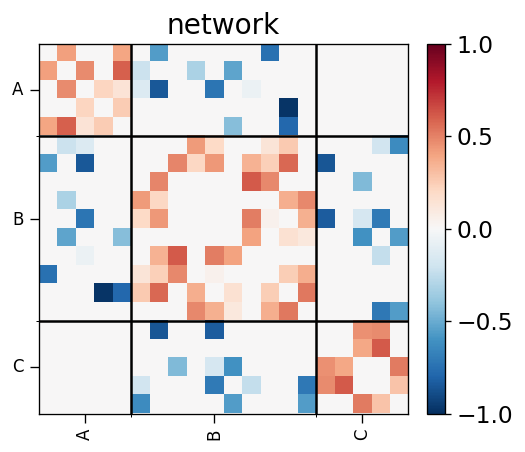

In [5]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

args.SEEDS = [100, 50, 75]
args.num_rois = np.array([5, 10, 5])
args.density = np.array([0.5, 0.3, 0.5])
args.scale = 1
args.group_label = ['A', 'B', 'C']

(
    network, 
    roi_labels,
) = generate_connectivity_matrix(args)

args = create_matrix_ticks(args)
args.cmap = mpl.colormaps['RdBu_r'] #cmr.iceburn # mpl.colormaps['Oranges']
display_network(args, network)

networks = [network]
args.num_rois = args.num_rois.sum(axis=0)
args.num_subjs = len(networks)
args.num_sigmas = 5
args.num_runs = 50

In [6]:
def to_python_vars(out_dict):
    for k, v in out_dict.items():
        out_dict[k] = np.array(v.tomemoryview().tolist())

    out_dict['t'] = out_dict['t'].squeeze()
    out_dict['x'] = out_dict['x'].T

    return out_dict
    
def simulate(eng, model_path, model, in_dict):
    eng.cd(model_path)
    out_dict = model(in_dict, nargout=1)
    out_dict = to_python_vars(out_dict)

    return out_dict

In [7]:
def get_average_fcs(args, fcs):
    fcs_avg = {
        f"subj{idx_subj:02}": {
            f"sigma{idx_sigma:02}": None
            for idx_sigma in range(args.num_sigmas)
        } 
        for idx_subj in range(args.num_subjs)
    }

    fcs_std = copy.deepcopy(fcs_avg)

    for (idx_subj, idx_sigma) in tqdm(
        list(product(range(args.num_subjs), range(args.num_sigmas)))
    ):
        fcs_ = np.stack(
            [
                fcs[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"][f"run{idx_run:02}"] 
                for idx_run in range(args.num_runs)
            ],
            axis=0,
        )
        fcs_avg[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"] = np.mean(fcs_, axis=0)
        fcs_std[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"] = np.std(fcs_, axis=0)
    
    return fcs_avg, fcs_std
        

In [8]:
def plot_roi_time_series(args, out_dicts, roi_labels=None):
    if any('run' in k for k in list(out_dicts.keys())):
        times = np.stack(
            [out_dicts[f"run{idx_run:02}"]['t'] for idx_run in range(args.num_runs)],
            axis=0,
        )
        xs = np.stack(
            [out_dicts[f"run{idx_run:02}"]['x'] for idx_run in range(args.num_runs)],
            axis=0,
        )
        time = np.mean(times, axis=0)
        data_mean = np.mean(xs, axis=0)
        data_std = 1.00 * np.std(xs, axis=0) #/ np.sqrt(xs.shape[0])
    elif any('x' in k for k in list(out_dicts.keys())):
        time = out_dicts['t']
        data_mean = out_dicts['x']
        data_std = np.zeros_like(data_mean)        

    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 5)), 5
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi in enumerate(np.arange(data_mean.shape[-1])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols] if nrows > 1 else axs[idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        
        if roi_labels is not None:
            ax.set_title(f"{roi_labels[roi]}")
        else:
            ax.set_title(f"roi {idx_roi+1:02}")

        ax.plot(
            time,
            data_mean[:, idx_roi],
            color='cornflowerblue',
            linewidth=3,
        )

        y1 = data_mean[:, idx_roi] - data_std[:, idx_roi]
        y2 = data_mean[:, idx_roi] + data_std[:, idx_roi]
        ax.fill_between(
            x=time, 
            y1=y1,
            y2=y2,
            color='cornflowerblue',
            alpha=0.5,
        )

        ax.plot(
            time,
            np.zeros_like(data_mean[:, idx_roi]),
            color='black',
            linewidth=1.5,
            linestyle='-.',
            alpha=0.5
        )

        ax.set_xlabel(f"time (ms)")
        ax.set_ylabel(f"activity")

        ax.grid(True)

    # fig.show()

    return None

In [9]:
args.tspan = [0, 100]
args.delta_t = 0.1

In [10]:
args.sigmas = np.linspace(start=0.0, stop=1.0, num=10, endpoint=False)
args.sigmas

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [11]:
stim_rois = np.array([2, 8, 17]) - 1
stimulus = np.zeros((args.num_rois,1))
stimulus[stim_rois[[0, 2]]] = 1.0
stimulus[stim_rois[1]] = -1.0

args.A = 0.75 * np.ones(shape=(args.num_rois,1))
# args.A[1,:] = 1.0 

in_dict = {}
# in_dict['W'] = networks[0]
in_dict['A'] = matlab.double(args.A)
in_dict['B'] = 1.0
in_dict['C'] = 1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 10.0
in_dict['T'] = 25.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)
# in_dict['sigma'] = 0.0

In [12]:
in_dicts = {
    f"subj{idx_subj:02}": {
        f"sigma{idx_sigma:02}": {
            f"run{idx_run:02}": {}
            for idx_run in range(args.num_runs)
        }
        for idx_sigma in range(args.num_sigmas)
    } 
    for idx_subj in range(args.num_subjs)
}

out_dicts = copy.deepcopy(in_dicts)

# time series simulation
eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_EI_balance_sde_model
for (idx_subj, idx_sigma) in tqdm(
    list(product(range(args.num_subjs), range(args.num_sigmas)))
):
    for idx_run in tqdm(range(args.num_runs)):
        in_dict['W'] = networks[idx_subj]
        in_dict['sigma'] = args.sigmas[idx_sigma]
        in_dict['randn'] = np.random.normal(
            loc=0.0,
            scale=1.0,
            size=(args.num_rois, 100*(args.tspan[-1] - args.tspan[0]),),
        )
        in_dicts[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"][f"run{idx_run:02}"] = copy.deepcopy(in_dict)
        
        out_dict = simulate(eng, model_path, model, in_dict)

        out_dicts[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"][f"run{idx_run:02}"] = copy.deepcopy(out_dict)
eng.quit()

100%|██████████| 5/5 [02:01<00:00, 24.32s/it]


100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


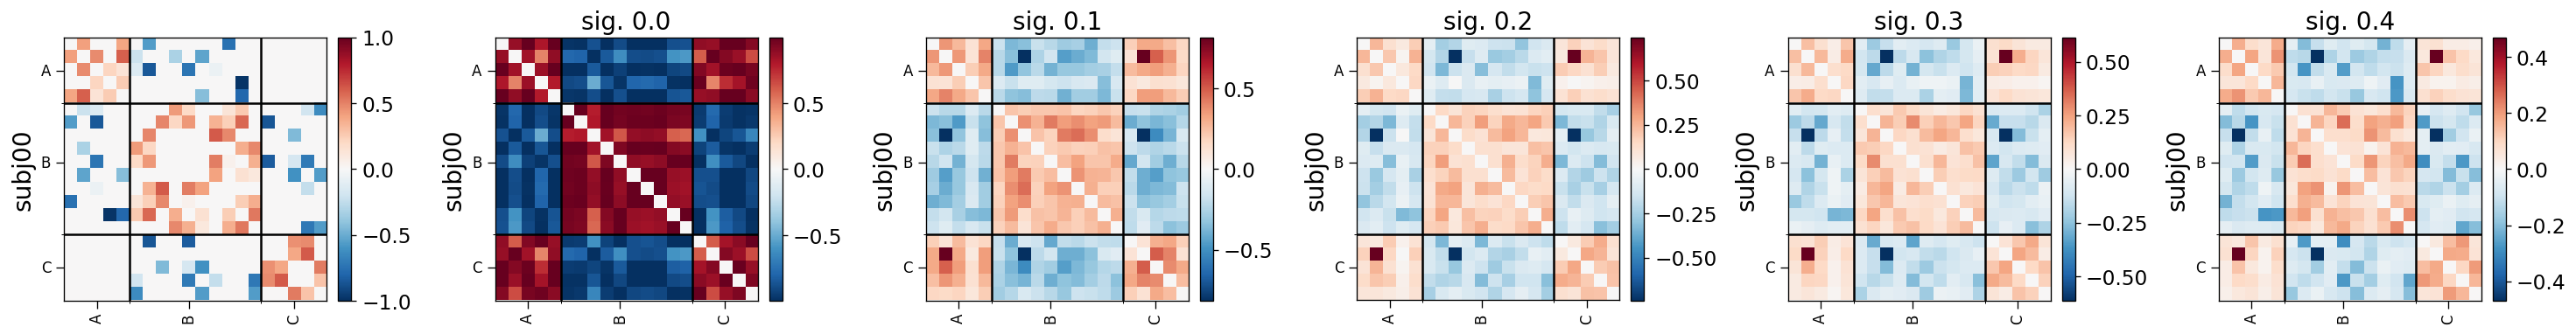

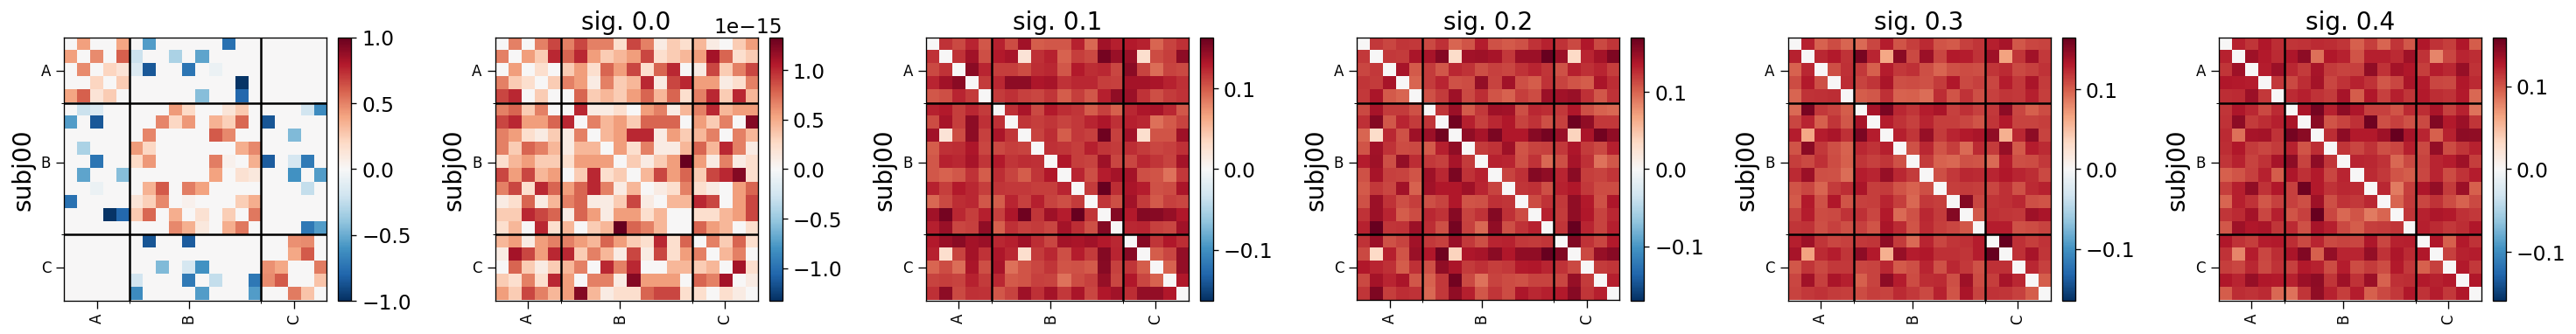

In [13]:
# functional connectivity
fcs = {
    f"subj{idx_subj:02}": {
        f"sigma{idx_sigma:02}": {
            f"run{idx_run:02}": None
            for idx_run in range(args.num_runs)
        }
        for idx_sigma in range(args.num_sigmas)
    } 
    for idx_subj in range(args.num_subjs)
}
for (idx_subj, idx_sigma) in tqdm(
    list(product(range(args.num_subjs), range(args.num_sigmas)))
):
    for idx_run in range(args.num_runs):
        out_dict = out_dicts[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"][f"run{idx_run:02}"]
        fc = stats.spearmanr(out_dict['x']).statistic
        np.fill_diagonal(fc, 0.0)
        # fc = np.log(fc)
        fcs[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"][f"run{idx_run:02}"] = fc

fcs_avg, fcs_std = get_average_fcs(args, fcs)
args.cmap = mpl.colormaps['RdBu_r'] #cmr.iceburn # mpl.colormaps['Oranges']
display_fcs(args, networks, fcs_avg)
display_fcs(args, networks, fcs_std)

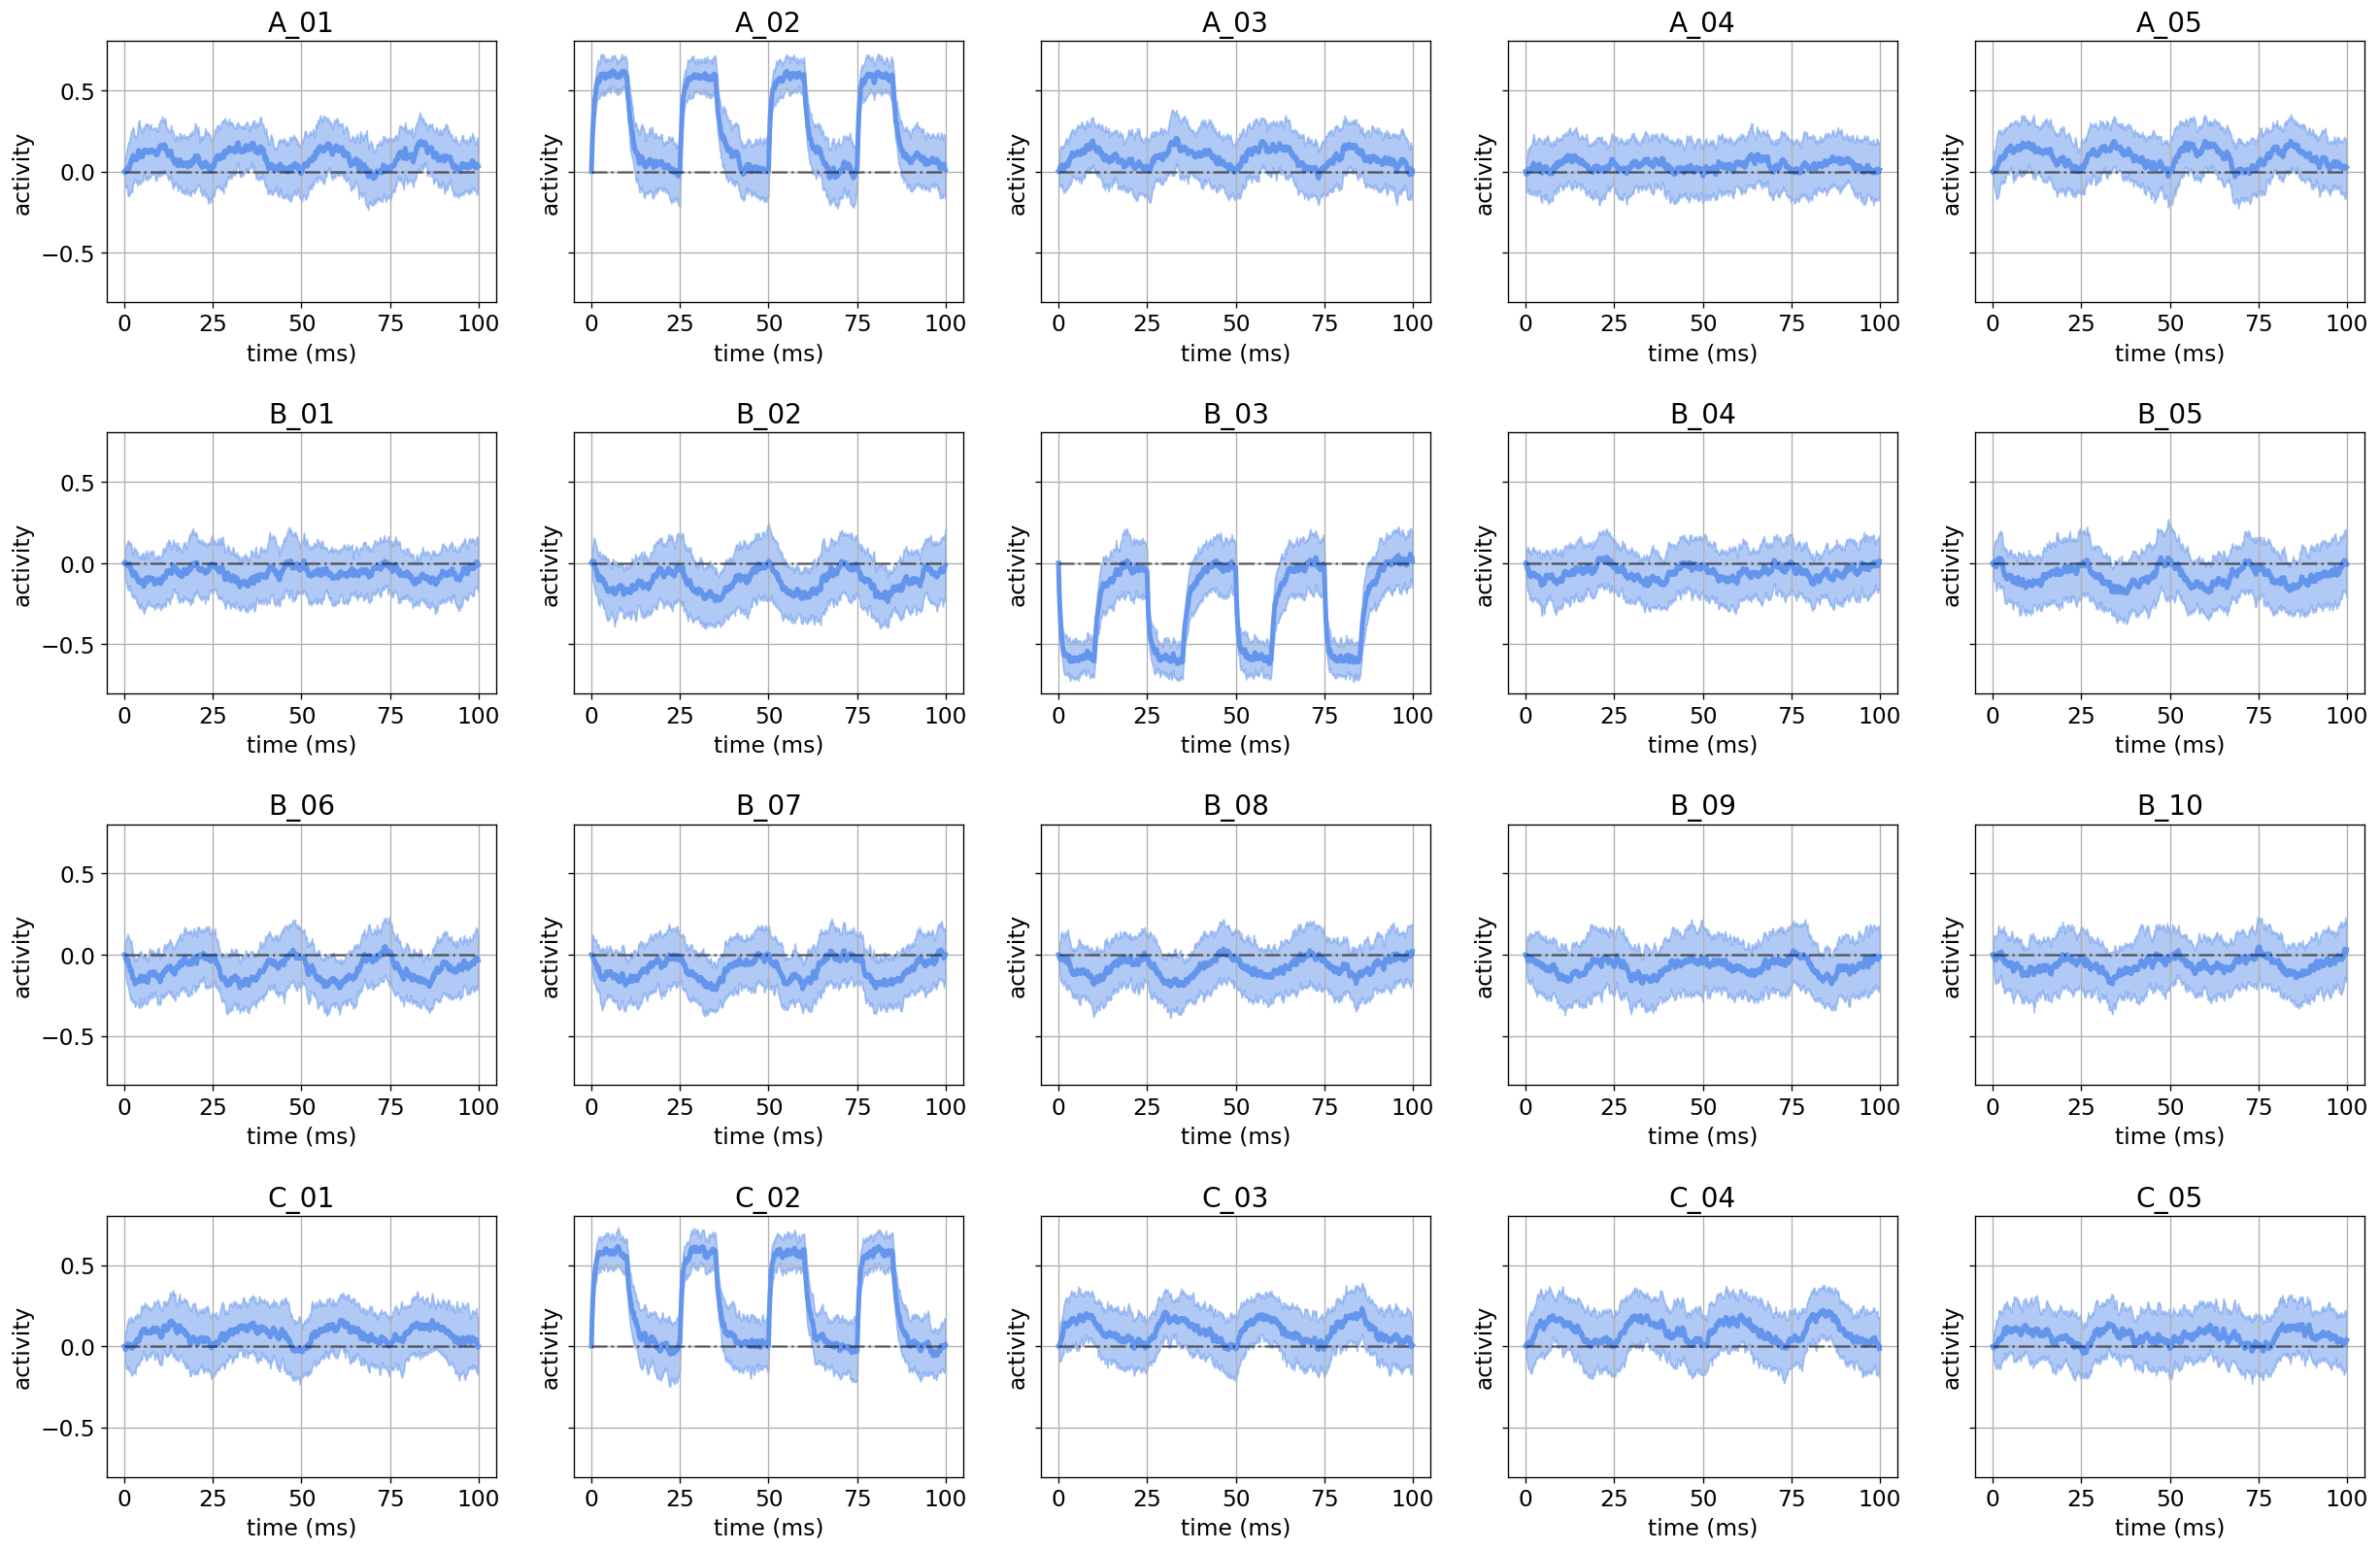

In [14]:
idx_subj, idx_sigma = 0, 2
args.subplot_layout = 'row-col'
plot_roi_time_series(
    args, 
    out_dicts[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"],#[f"run{8:02}"],
    roi_labels,
)

# plt.figure()
# args.cmap = mpl.colormaps['RdBu_r'] #cmr.iceburn # mpl.colormaps['Oranges']
# plt.imshow(
#     fcs_avg[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"], 
#     cmap=args.cmap)
# plt.colorbar()
# plt.title('fc')